# Visualization

In this Pandas tutorial you will use Pandas to explore ChIP-seq and DNase-seq footprinting datasets for 3 different celltypes from the Roadmap data: 

* E081: Fetal Brain Male
* E082: Fetal Brain Female
* E083: Fetal Heart

Before we start, import the appropriate modules 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Set directory for the data files
DATA_DIR = "/vol/cursus/CFB/visual"

In [2]:
# Set directory for the data files
# Only for building the book!
DATA_DIR = "../data/visual"

Note that by doing this:

* we import three modules: 
    * `pandas`, a module that allows us to work with DataFrames
    * `numpy`, a module for scientific calculations
    * `pyplot` functionality from the module `matplotlib`
    * `seaborn`, a module for making pretty plots
* we make sure that
    * `pandas` commands can be called with `pd.`
    * `numpy` commands can be called with `np.`
    * `pyplot` commands can be called with `plt.`
    * `seaborn` commands can be called with `sns.`
* `%matplotlib inline`: we make sure that all plotting is going to be shown "inline" with our commands (in Jupyter)


## H3K4me1 and H3K4me3 marking in promoters and enhancers in Fetal Brain

Next, we can import the data for E082 into pandas DataFrames, using the `read_csv()` function. Note: in earlier versions of pandas you could use the `read_table()` function, however, in newer versions of pandas this function has been deprecated and will be removed.



In [3]:
E082_prom_K4me1 = pd.read_csv(f"{DATA_DIR}/hg19_RefSeq_TSS500__E082-H3K4me1.counts.gz", 
                                sep="\t", # The files are tab-separated 
                                names=['chr', 'start', 'end', 'reads'])
E082_enh_K4me1 = pd.read_csv(f"{DATA_DIR}/regions_enh_E081_E082_E083__E082-H3K4me1.counts.gz",
                                sep="\t", # The files are tab-separated 
                                names=['chr', 'start', 'end', 'reads'])
E082_prom_K4me3 = pd.read_csv(f"{DATA_DIR}/hg19_RefSeq_TSS500__E082-H3K4me3.counts.gz",
                                sep="\t", # The files are tab-separated 
                                names=['chr', 'start', 'end', 'reads'])
E082_enh_K4me3 = pd.read_csv(f"{DATA_DIR}/regions_enh_E081_E082_E083__E082-H3K4me3.counts.gz",
                                sep="\t", # The files are tab-separated 
                               names=['chr', 'start', 'end', 'reads'])

For each DataFrame, make columns with the corresponding annotation


In [4]:
E082_prom_K4me1['elem'] = 'prom'
E082_enh_K4me1['elem'] = 'enh'
E082_prom_K4me3['elem'] = 'prom'
E082_enh_K4me3['elem'] = 'enh'

E082_prom_K4me1['mark'] = 'H3K4me1'
E082_enh_K4me1['mark'] = 'H3K4me1'
E082_prom_K4me3['mark'] = 'H3K4me3'
E082_enh_K4me3['mark'] = 'H3K4me3'

Check the result by doing a `head()` on some of the DataFrames ( `df.head()`, where `df` is the object name of the DataFrame )

Concatenate the DataFrames into one DataFrame (all DataFrame rows will be added to one big DataFrame)


In [5]:
E082 = pd.concat([E082_prom_K4me1, E082_enh_K4me1, E082_prom_K4me3, E082_enh_K4me3])


Make a boxplot of H3K4me1, H3K4me3 in promoters and enhancers


<AxesSubplot:xlabel='elem', ylabel='reads'>

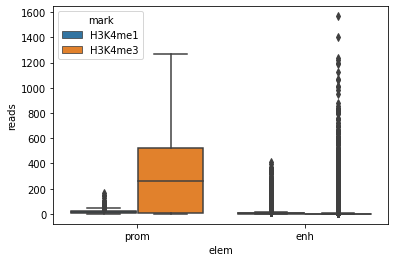

In [6]:
sns.boxplot(x="elem", y="reads", hue="mark", data=E082)


Note how the synthax for `boxplot` is assembled: 

* Use the column with name `elem` as a grouping of boxes along the x-axis
* Use the column with name `reads` as the value to plot along the y-axis
* Use the column with name `mark` to differentially color the boxes

Make sure you understand how this works.



There are lots of outliers (dots stacked on top of each box/whisker) which do not contribute much to the plot

It is probably better to not plot the outliers 

<AxesSubplot:xlabel='elem', ylabel='reads'>

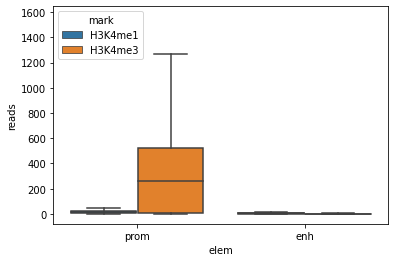

In [7]:
sns.boxplot(x="elem", y="reads", hue="mark", fliersize=0, data=E082)


This is better already, but the boxplots are all at the bottom of the graph, this does not help much for clarity.

If you do a **data transformation**, the plot may look better.

For readcounts (integers ranging from 0 up to ...) a squareroot transformation can work well since it handles zeros well (log-transformation does not handle the zeros).

Repeat the boxplot on the transformed data.

<AxesSubplot:xlabel='elem', ylabel='reads_sqrt'>

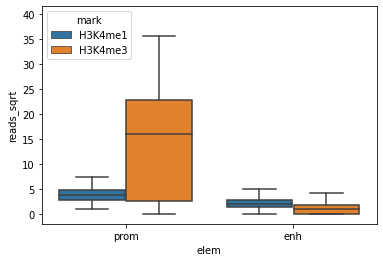

In [8]:
E082['reads_sqrt'] = np.sqrt(E082['reads'])
sns.boxplot(x="elem", y="reads_sqrt", hue="mark", fliersize=0, data=E082)


Knowing that the regions in the DataFrame are not of the same length, we may need to correct the transformed readcounts for the length of the regions


<AxesSubplot:xlabel='elem', ylabel='reads_sqrt_bp'>

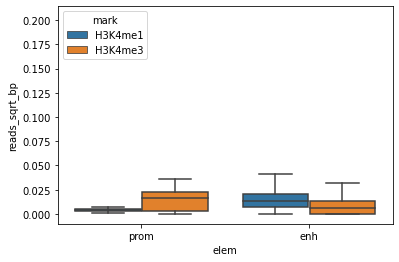

In [9]:
E082['reads_sqrt_bp'] = E082['reads_sqrt']/(E082['end']-E082['start'])
sns.boxplot(x="elem", y="reads_sqrt_bp", hue="mark", fliersize=0, data=E082)


This is definitely better, but the plot may even better if we adapt the y-axis scale


<AxesSubplot:xlabel='elem', ylabel='reads_sqrt_bp'>

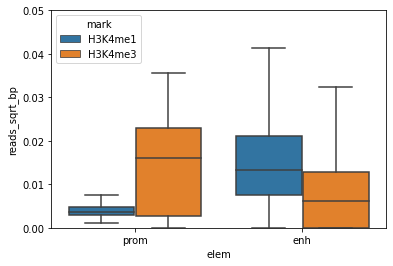

In [10]:
plt.ylim(0,0.05)
sns.boxplot(x="elem", y="reads_sqrt_bp", hue="mark", fliersize=0, data=E082)


Great, this is a nice boxplot.

What can you conclude for H3K4me3 and H3K4me1 in promoters and enhancers?


## H3K4me1 and H3K4me3 marking in promoters and enhancers: Fetal Brain-specific enhancers only

In the previous section we used all enhancers that were called in Fetal Brain (male and Female) and Fetal Heart, but maybe we should include only those enhancers that were really called as an enhancer in E082 (Fetal Brain Female)

This information is in the file `regions_enh_E081_E082_E083.bed`, which you find in the `/vol/cursus/CFB/visual` directory.

This file has the same order as all files above that are called  `regions_enh_E081_E082_E083__xxxxx`.

Read the file into a pandas DataFrame.


In [11]:
enh = pd.read_csv(f"{DATA_DIR}/regions_enh_E081_E082_E083.bed.gz",
                    sep="\t",
                    names=['chr', 'start', 'end', 'celltype'])


Do a head to see what the file looks like.

To select all the regions that are called as enhancer in E082, we will create a **boolean** that consists of `True` / `False` indicating which line (=region, =enhancer) in the `enh` DataFrame refers to an enhancer in E082.



In [12]:
cond = enh['celltype'].str.contains('E082')


Remember that the order of the `enh` DataFrame was the same as for all enhancer DataFrames.

Now we take the individual enhancer DataFrames for E082 (not the concatenated one) and select from those only the E082-specific enhancer regions


In [13]:
E082_enh_K4me1_spec = E082_enh_K4me1[cond]
E082_enh_K4me3_spec = E082_enh_K4me3[cond]


Now that we have selected the E082-specific enhancers only, we can concatenate the DataFrames like we did above


In [14]:
E082_spec = pd.concat([E082_prom_K4me1, E082_enh_K4me1_spec, E082_prom_K4me3, E082_enh_K4me3_spec])


Like above, we do the sqrt transformation and length-correction


In [15]:
E082_spec['reads_sqrt'] = np.sqrt(E082_spec['reads'])
E082_spec['reads_sqrt_bp'] = E082_spec['reads_sqrt']/(E082_spec['end']-E082_spec['start'])


We can now make the boxplot as we did above


<AxesSubplot:xlabel='elem', ylabel='reads_sqrt_bp'>

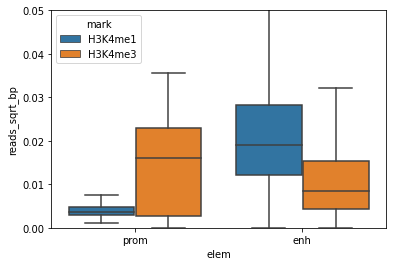

In [16]:
plt.ylim(0,0.05)
sns.boxplot(x="elem", y="reads_sqrt_bp", hue="mark", fliersize=0, data=E082_spec)


Do you see a difference with the boxplot above?

Does this make sense (H3K4me is a typical enhancer mark) ?


## Enhancer marking in different cell types

Now let us look at H3K4me1 data only, in enhancers only, but in different cell types

We will add data from a different cell type, E081 (Fetal Brain Male), E082 (Fetal Brain Female) and E083 (Fetal Heart)

First, read in the data into a pandas DataFrame again


In [17]:
E081_enh_K4me1 = pd.read_csv(f"{DATA_DIR}/regions_enh_E081_E082_E083__E081-H3K4me1.counts.gz",
                                sep="\t", 
                                names=['chr', 'start', 'end', 'reads'])
E082_enh_K4me1 = pd.read_csv(f"{DATA_DIR}/regions_enh_E081_E082_E083__E082-H3K4me1.counts.gz",
                                sep="\t", 
                                names=['chr', 'start', 'end', 'reads'])
E083_enh_K4me1 = pd.read_csv(f"{DATA_DIR}/regions_enh_E081_E082_E083__E083-H3K4me1.counts.gz",
                                sep="\t", 
                                names=['chr', 'start', 'end', 'reads'])

In each DataFrame, annotate from which celltype the data comes in a column called `celltype`. 



In [18]:
E081_enh_K4me1['celltype'] = "E081"
E082_enh_K4me1['celltype'] = "E082"
E083_enh_K4me1['celltype'] = "E083"

In each DataFrame, annotate the enhancers that were called for each cell type.

We create a column called `enh` which denotes whether a region was called as enhancer in E081, E082, or E083.

This data we take from the DataFrame `enh`, from which we know that the order is the same as in our DataFrames.


In [19]:
E081_enh_K4me1['enh'] = enh['celltype']
E082_enh_K4me1['enh'] = enh['celltype']
E083_enh_K4me1['enh'] = enh['celltype']

Like above, we make a concatenated DataFrame `m` using `concat`.


In [20]:
m = pd.concat([E081_enh_K4me1, E082_enh_K4me1, E083_enh_K4me1])


Like above, we transform the readcounts using `sqrt`, and correct for region length.


In [21]:
m['reads_sqrt'] = np.sqrt(m['reads'])
m['reads_sqrt_bp'] = m['reads_sqrt']/(m['end']-m['start'])

Now we can make the boxplot.

Note that we add an extra argument called `hue` which colors the boxplot according the information in the column called `enh`.


(0.0, 0.08)

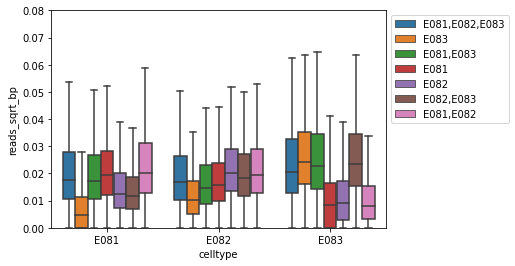

In [22]:
sns.boxplot(x="celltype", y="reads_sqrt_bp", hue="enh", fliersize=0, data=m)

# Move legend outside the plot
plt.legend(bbox_to_anchor=(1, 1), loc=2)

# Adapt the y-axis
plt.ylim(0, 0.08)

Carefully look at the boxplot

Does this make sense?


## Promoter marking vs. gene expression

You are going to plot the gene expression (RNA-seq, so RPKM) as a function of the active promoter mark H3K4me3 at the corresponding genes, for E082.

For this you need the file `hg19_RefSeq_TSS500_ENSEMBL_RPKM` from the `/vol/cursus/CFB/visual` directory.

This file has the same ordering as all files named `hg19_RefSeq_TSS500__xxxxx`.

First, read in the expression data into a pandas DataFrame.

In [24]:
rpkm = pd.read_csv(f"{DATA_DIR}/hg19_RefSeq_TSS500_ENSEMBL_RPKM.gz", sep="\t")


Check with a `head()` what this file looks like. Note that we did not specify column names, since these are already present in the file. `read_csv by default assumes that this first line is a header line

Note that `head()` does not show you all columns, so you can use the following to see all column names


In [25]:
rpkm.columns


Index(['chr', 'start', 'end', 'refseq', 'gene', 'strand', 'ensembl', 'E000',
       'E003', 'E004', 'E005', 'E006', 'E007', 'E011', 'E012', 'E013', 'E016',
       'E024', 'E027', 'E028', 'E037', 'E038', 'E047', 'E050', 'E053', 'E054',
       'E055', 'E056', 'E057', 'E058', 'E059', 'E061', 'E062', 'E065', 'E066',
       'E070', 'E071', 'E079', 'E082', 'E084', 'E085', 'E087', 'E094', 'E095',
       'E096', 'E097', 'E098', 'E100', 'E104', 'E105', 'E106', 'E109', 'E112',
       'E113', 'E114', 'E116', 'E117', 'E118', 'E119', 'E120', 'E122', 'E123',
       'E127', 'E128'],
      dtype='object')

The DataFrame `rpkm` has many columns, you need to paste the column called `E082` to a DataFrame called `E082_prom_K4me3`

In [27]:
E082_prom_K4me3 = pd.read_csv(f"{DATA_DIR}/hg19_RefSeq_TSS500__E082-H3K4me3.counts.gz",
                                sep="\t",
                                names=['chr', 'start', 'end', 'reads'])

Like above, do the sqrt transformation on the H3K4me3 readcounts.


In [28]:
E082_prom_K4me3['reads_sqrt'] = np.sqrt(E082_prom_K4me3['reads'])


In this case there is no need to normalize for region length since all promoters here have the same length. However if you do normalize, it does not matter


Since the order of the regions (=lines) in the `rpkm` DataFrame is the same as in the `E082_prom_K4me3` DataFrame, we can paste the RPKM column `E082` from the `rpkm` DataFrame into the `E082_prom_K4me3` DataFrame.


In [29]:
E082_prom_K4me3['rpkm'] = rpkm['E082']


Now we can make a scatterplot, in which each dot represent a promoter and the RPKM of the corresponding gene.

We use the function `lmplot()` from seaborn.


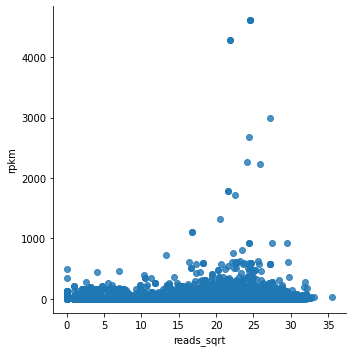

In [30]:
sns.lmplot(x='reads_sqrt', y='rpkm', data=E082_prom_K4me3, fit_reg=False)


Note that `lmplot()` by default plots a regression line, which you can turn off by `fit_reg=False`.

Looking at the plot, we can say that this does not look fantastic....

Most dots are at the bottom of the graph, and we cannot see whether there is any correlation.

For gene expression it is usually good to plot it in log-scale.

In this case we choose the log2, but a log10 would be fine as well.

/home/simon/anaconda3/envs/cfb/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


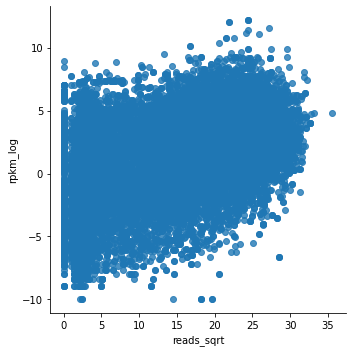

In [31]:
E082_prom_K4me3['rpkm_log'] = np.log2(E082_prom_K4me3['rpkm'])
sns.lmplot(x='reads_sqrt', y='rpkm_log', data=E082_prom_K4me3, fit_reg=False)


This looks much better.

Although the relationship is not clear-cut, there is definitely a trend of higher expression for genes which promoters have higher H3K4me3.

We can think about a control for this analysis.

To check whether the observed trend has some biological meaning, we can plot the same gene expression from **E082** as a function of H3K4me3 in **E083** (the 'wrong' celltype).

The expectation is that the trend you observed above is less clear here.

Read the promoter H3K4me3 data into a pandas DataFrame as we did above


In [33]:
E083_prom_K4me3 = pd.read_csv(f"{DATA_DIR}/hg19_RefSeq_TSS500__E083-H3K4me3.counts.gz",
                                sep="\t",
                                names=['chr', 'start', 'end', 'reads'])

Do the sqrt transformation of the H3K4me3 readcounts, as above.

Paste the RPKMs into the H3K4me3 DataFrame of E083, as above.

Do the RPKM log2 transformation, as above.

In [34]:
E083_prom_K4me3['reads_sqrt'] = np.sqrt(E083_prom_K4me3['reads'])
E083_prom_K4me3['rpkm'] = rpkm['E082']
E083_prom_K4me3['rpkm_log'] = np.log2(E083_prom_K4me3['rpkm'])

/home/simon/anaconda3/envs/cfb/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


And then the scatterplot.


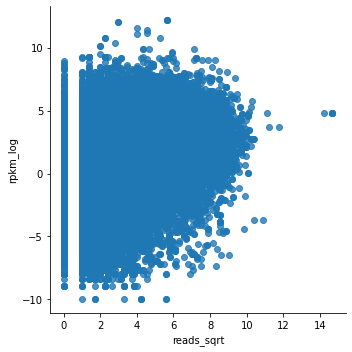

In [35]:
sns.lmplot(x='reads_sqrt', y='rpkm_log', data=E083_prom_K4me3, fit_reg=False)


As an alternative to the scatterplot approach above, we can classify our H3K4me3 levels into 'high' or 'low'. But, what is 'high' and what is 'low'? Where should we put the threshold for 'high'?

To get an idea, we can plot the distribution of the H3K4me3 signal using a histogram/densityplot. For this we use the `distplot` function from seaborn.


<AxesSubplot:xlabel='reads_sqrt'>

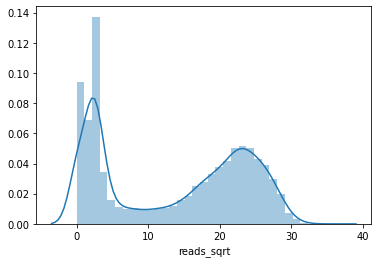

In [36]:
sns.distplot(E082_prom_K4me3['reads_sqrt'])

By looking at this histogram, we could conclude that the regions with 'high' H3K4me3 are the ones that roughly have signals higher than 15 or so.

To assign 'high' and 'low' to H3K4me3 levels we add a column to the E082 DataFrame called `reads_sqrt_bin`.

For this we use the `where` function from numpy, in which we state: if the values in column x are higher than 15, return "high H3K4me3", else, return "low H3K4me3".


In [37]:
E082_prom_K4me3['reads_sqrt_bin'] = np.where(E082_prom_K4me3['reads_sqrt'] > 15, "high K4me3", "low K4me3")


Do a `head()` on the DataFrame to see what happened.

Now we can use a boxplot instead of a scatterplot.

In this boxplot the RPKM is plotted in boxes, as a function of "high K4me3" or "low K4me3".


<AxesSubplot:xlabel='reads_sqrt_bin', ylabel='rpkm_log'>

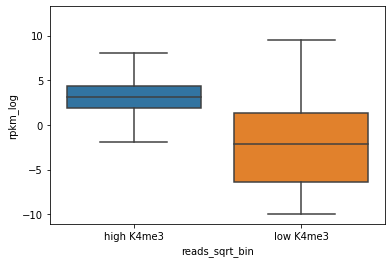

In [38]:
sns.boxplot(x="reads_sqrt_bin", y="rpkm_log", fliersize=0, data=E082_prom_K4me3)


In this plot it is already much more clear that gener with high H3K4me3 at the promoter have higher expression.

Rather than assigning two "bins" ("high" and "low") by ourselves, we can specify multiple bins.

For this we use the `cut` method of pandas, for which we can specify the number of bins we want.


In [39]:
E082_prom_K4me3['reads_sqrt_bin'] = pd.cut(E082_prom_K4me3['reads_sqrt'], 3, labels=False)


Note that we used `labels=False`, which causes the bins to be numbered.

We can now make a similar boxplot as above, with the RPKM plotted in boxes, as a function of the different bins we created.


<AxesSubplot:xlabel='reads_sqrt_bin', ylabel='rpkm_log'>

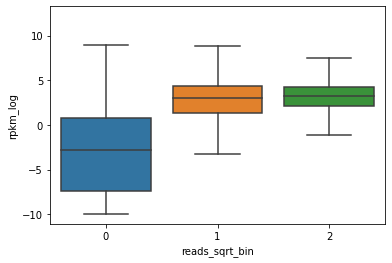

In [40]:
sns.boxplot(x="reads_sqrt_bin", y="rpkm_log", fliersize=0, data=E082_prom_K4me3)


## Exercises


**Exercise 12.1 Visualization using pandas and seaborn**

In this exercise you are going to compare the different ChIP-seq and DNase-seq datasets from 

* E081: Fetal Brain Male
* E082: Fetal Brain Female
* E083: Fetal Heart

The final goal is to see **how these marks correlate**, and **how these marks classify the different cell types**.
You will visualize this in a **heatmap** that shows **pairwise correlations**, and clusters the datasets that are most similar.  

To get to this, the exercise is divided into different questions that will lead you through the exercise.
By the way, for help you are allowed (=encouraged) to use Google as well!

**Exercise outline**

The strategy is outlined here, a detailed description follows after this:

* Make a dictionary with pandas DataFrames, so that object names can be used to access the DataFrames
    * Q1. Create a definition to read files into pandas DataFrames
    * Q2. Create lists with filenames and their corresponding object names
    * Q3. Create the dictionary with DataFrames
* Q4. Make one merged DataFrame containing the readcounts as columns, one for each datasets.
* Q5. Make a DataFrame with all pairwise correlations
* Q6. Plot the heatmap of pairwise correlations

**Question 1. Function for reading a file into a pandas DataFrame**

Write a definition (function) that:

* uses a filename as input (e.g. `dirname_xxxxx/filename_xxxxx`)
* returns the corresponding pandas DataFrame
* this should work for files with four columns (e.g. named 'chr', 'start', 'end', 'reads')


**Question 2. Create lists with filenames and object names**

The directory `/vol/cursus/CFB/visual` contains:

* readcounts for promoters (`hg19_RefSeq_TSS500__xxxxx.counts.gz`)
* readcounts for enhancers (`regions_enh_E081_E082_E083__xxxxx.counts.gz`)

Create 4 lists: 

1. filenames (e.g. `dirname_xxxxx/filename_xxxxx`) for all promoter files with
    * DNase
    * H3K4me3
    * H3K27me3

2. filenames (e.g. `dirname_xxxxx/filename_xxxxx`) for all enhancer files with
    * DNase
    * H3K4me1
    * H3K27me3
3. object names for all promoter files of list 1. (e.g. `"E082-H3K27me3"`)
4. object names for all enhancer files of list 2. (e.g. `"E082-H3K4me1"`)

Note: these filenames should contain the full path to the file

Note: it is OK to create the lists with filenames manually, but the lists with object names can be derived from the former, using python. 

**Question 3. Make a dictionary with DataFrames**

Make a dictionary with DataFrames with

* object names as **keys** (e.g. `"E081-H3K4me1"`, use the list with object names created above)
* the corresponding pandas DataFrame as **values** (use the list with filenames created above) 

Make one such dictionary for promoters, and one dictionary for enhancers

**Question 4. Make a merged DataFrame with readcounts**

Make a new pandas DataFrame in which the columns contain the readcounts from each DataFrame in your dictionary

* one DataFrame for the promoters
* one DataFrame for the enhancers 

To do this, you can use a loop over your dictionaries and create a new DataFrame column by column.


**Question 5. Make a DataFrame with pairwise correlations**

Make a pandas DataFrame containing the pairwise correlations between the different datasets

* one DataFrame for the promoters
* one DataFrame for the enhancers

Hint: you can do this by using the `corr()` method for a pandas DataFrame


**Question 6. Plot a heatmap displaying the pairwise correlations**

Plot a heatmap that displays the correlation coefficients obtained in the DataFrame above.

* Make one heatmap for the promoters
* Make one heatmap for the enhancers

Hint: you can do this by using the `clustermap()` function for a pandas DataFrame, which will not only draw the heatmap, but also cluster the heatmap


Which of the two, promoters or enhancers, are best for classifying the different celltypes?